In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import scanpy as sc

from matplotlib import pyplot as plt
from matplotlib import rcParams
import seaborn as sns

from micron2.spatial import get_neighbors, categorical_neighbors, sliding_window_niches, k_neighbor_niches
import statannot

import tqdm.auto as tqdm

rcParams['figure.facecolor'] = (1,1,1,1)
rcParams['svg.fonttype'] = 'none'

In [2]:
"""
Diversity functions by K.H.G, 2021
""" 
## calculate Gini coefficient
## from: http://www.statsdirect.com/help/default.htm#nonparametric_methods/gini.htm
# def gini(adata, colname):
def gini(data):

    vals = data.value_counts()
    vals = vals[vals>0].to_numpy()

    vals = vals.flatten() #all values are treated equally, tcrs must be 1d 
    vals = np.sort(vals) #values must be sorted
    index = np.arange(1,vals.shape[0]+1) #index per tcrs element
    n = vals.shape[0] #number of tcrs elements
    
    return ((np.sum((2 * index - n  - 1) * vals)) / (n * np.sum(vals))) #Gini coefficient

## calculate normalized shannon entropy clonality
## clonality = 1 - (SE/ln(# of tcrs))
# def shannon(adata, colname):
def shannon(data):

    totalsize = len(data)

    vals = data.value_counts()
    vals = vals/totalsize
    numel = len(vals)
    
    runningSum = 0
    
    for i in vals:
        runningSum += -1*(i * np.log(i))

#     return (1 - (runningSum/np.log(numel)))
    return runningSum/np.log(numel)

In [3]:
adata = sc.read_h5ad("/storage/codex/datasets_v1/bladder_merged_v10.h5ad")
subtype_2 = np.array(adata.obs.subtype)
subtype_2[subtype_2 == 'Epithelial_KRT13'] = 'Epithelial_KRT13_KRT17'
subtype_2[subtype_2 == 'Epithelial_KRT17'] = 'Epithelial_KRT13_KRT17'
adata.obs['subtype_2'] = pd.Categorical(subtype_2)

adata

AnnData object with n_obs × n_vars = 598327 × 1440
    obs: 'CD45_ringpct', 'CD20_ringpct', 'CD3e_ringpct', 'CD45RO_ringpct', 'CD45RA_ringpct', 'CD8_ringpct', 'CD4_ringpct', 'CDH12_ringpct', 'KRT13_ringpct', 'KRT17_ringpct', 'PanCytoK_ringpct', 'ERBB2_ringpct', 'sample_id', 'sample_id_printing', 'snSeq_sample', 'patient', 'biopsy', 'Filtered_DAPI', 'cell_gates', 'celltype_gating', 'subtype_gates', 'subtype_gating', 'subtype_rescued', 'subtype', 'celltype', 'cell_niches', 'niche_labels', 'subtype_2'
    uns: 'celltype_colors', 'channels', 'niche_labels_colors', 'niche_profiles_colnames', 'patient_colors', 'sample_id_printing_colors', 'sample_layout', 'snSeq_sample_colors', 'subtype_colors', 'subtype_gating_colors'
    obsm: 'coordinates', 'coordinates_shift', 'niche_profiles'

In [16]:
samples = np.array(adata.obs.sample_id)
niches = np.array(adata.obs.niche_labels)
celltypes = np.array(adata.obs.niche_labels)

subtypes = np.array(adata.obs.subtype_2)

u_samples = np.unique(samples)
u_niches = np.unique(niches)
u_celltype = np.unique(celltypes)

min_cells = 25
max_dist = 200
s = u_samples[0]

gini_df = pd.DataFrame(index=u_samples, columns=u_celltype, dtype=np.float32)
shannon_df = pd.DataFrame(index=u_samples, columns=u_celltype, dtype=np.float32)

for s in tqdm.tqdm(u_samples):
    ad = adata[samples == s]
    sample_celltypes = subtypes[samples==s]
    sample_groups = celltypes[samples==s]
    coords = ad.obsm['coordinates']
    neighbors, distances = get_neighbors(coords, k=10, return_distances=True, backend='rapids')
    neighbors = np.array(neighbors)
    distances = np.array(distances)

    for ct in u_celltype:
        neighbor_ids = []
        niche_cells = sample_groups == ct
        if np.sum(niche_cells) < min_cells:
            continue
            
        niche_neighbors = neighbors[niche_cells,:]
        niche_distances = distances[niche_cells,:]

        for ns, ds in zip(niche_neighbors, niche_distances):
            ns = ns[ds < max_dist]
            neighbor_ids += list(ns)

        niche_celltypes = sample_celltypes[ np.array(list(set(neighbor_ids))) ]
        g = gini(pd.Series(niche_celltypes))
        sh = shannon(pd.Series(niche_celltypes))
        
        gini_df.loc[s, ct] = g
        shannon_df.loc[s, ct] = sh

  0%|          | 0/75 [00:00<?, ?it/s]

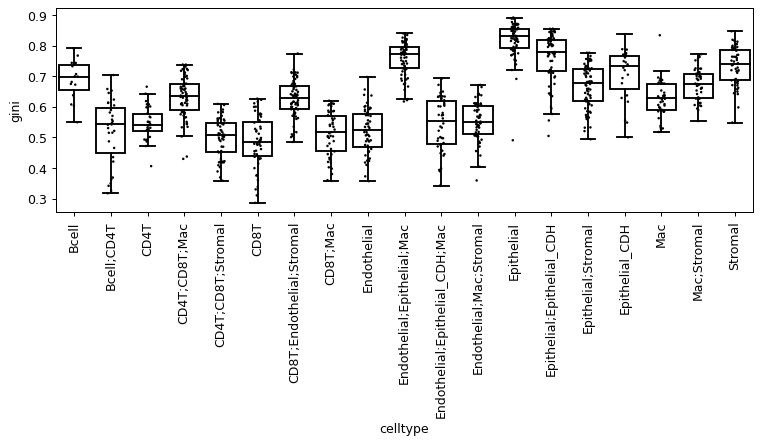

In [17]:
import itertools
vals = gini_df.melt()
vals.columns = ['celltype', 'gini']

order = ['Epithelial_KRT13_KRT17', 'Epithelial_CDH']
order = u_celltype

plt.figure(figsize=(10,3), dpi=90)
ax = plt.gca()
sns.boxplot(x = 'celltype', y = 'gini', data = vals,  order = order, ax=ax, color='w', fliersize=0)
sns.stripplot(x = 'celltype', y = 'gini', data = vals,  order = order, ax=ax, color='k', s=2)
# _ = statannot.add_stat_annotation(x = 'celltype', y = 'gini', data = vals,  order = order, ax=ax,
#                                   box_pairs = [(c1,c2) for c1,c2 in itertools.combinations(order,2)],
#                                   test = 't-test_ind', text_format='simple', verbose=0,
#                                   comparisons_correction = None
#                                  )
_ = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
for i,box in enumerate(ax.artists):
    box.set_edgecolor('black')

    # iterate over whiskers and median lines
    for j in range(6*i,6*(i+1)):
         ax.lines[j].set_color('black')
            
# plt.savefig('figures/gini_epithelial_niches.svg', bbox_inches='tight', transparent=True)

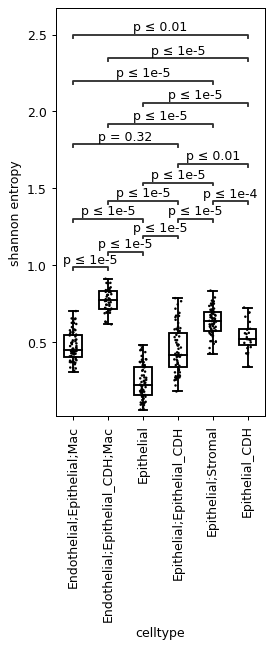

In [20]:
vals = shannon_df.melt()
vals.columns = ['celltype', 'shannon entropy']

# order = ['Epithelial_KRT13_KRT17', 'Epithelial_CDH']
order = [l for l in u_celltype if 'Epithelial' in l]
plt.figure(figsize=(3,6), dpi=90)
ax = plt.gca()
sns.boxplot(x = 'celltype', y = 'shannon entropy', data = vals,  order = order, ax=ax, color='w', fliersize=0, width=0.5)
sns.stripplot(x = 'celltype', y = 'shannon entropy', data = vals,  order = order, ax=ax, color='k', s=2)
_ = statannot.add_stat_annotation(x = 'celltype', y = 'shannon entropy', data = vals,  order = order, ax=ax,
                                  box_pairs = [(c1,c2) for c1,c2 in itertools.combinations(order,2)],
                                  test = 't-test_ind', text_format='simple', verbose=0, comparisons_correction=None
                                 )
_ = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
for i,box in enumerate(ax.artists):
    box.set_edgecolor('black')

    # iterate over whiskers and median lines
    for j in range(6*i,6*(i+1)):
         ax.lines[j].set_color('black')
            
plt.savefig('figures/shannon_entropy_by_niche_epithelial_niches.svg', bbox_inches='tight', transparent=True)